# Evaluation History - Segmentation Masks

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import datetime

import numpy as np

from src.data import train_test_split, MRISequence
from src.model import create_model, compile_model, load_checkpoint
from src.model.evaluation import show_metrics

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['image.cmap'] = 'viridis'

%config InlineBackend.figure_format='retina'
plt.rcParams.update({'font.size': 15})

In [3]:
import tensorflow as tf

# RANDOM_SEED = 250398
# tf.random.set_seed(RANDOM_SEED)

print(tf.version.VERSION)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.3.2
Num GPUs Available:  1


## Setup

In [207]:
%%time

ROOT_DIR = '../../tmp'
DEFAULT_CHECKPOINT_DIRECTORY_LOCAL = os.path.join(ROOT_DIR, 'checkpoints')
DEFAULT_BCKP_CHECKPOINT_DIRECTORY_LOCAL = os.path.join(ROOT_DIR, 'bckp-checkpoints')

LOG_DIRECTORY = os.path.join(ROOT_DIR, 'logs')
CHECKPOINT_DIRECTORY = DEFAULT_CHECKPOINT_DIRECTORY_LOCAL

LOG_DIRECTORY_LOCAL = LOG_DIRECTORY
CHECKPOINT_DIRECTORY_LOCAL = CHECKPOINT_DIRECTORY

DATA_DIR_NAME = 'data-v3'
DATA_DIR = os.path.join(ROOT_DIR, DATA_DIR_NAME)

saliencies_and_segmentations_v2_path = os.path.join(ROOT_DIR, 'saliencies_and_segmentations_v2')

if not os.path.exists(CHECKPOINT_DIRECTORY):
    os.mkdir(CHECKPOINT_DIRECTORY)

if not os.path.exists(LOG_DIRECTORY):
    os.mkdir(LOG_DIRECTORY)

val = False

class_names = ['AD', 'CN']

# get paths to data
train_dir, test_dir, val_dir = train_test_split(
    saliencies_and_segmentations_v2_path,
    ROOT_DIR,
    split=(0.8, 0.15, 0.05),
    dirname=DATA_DIR_NAME)

# set the batch size for mri seq
batch_size = 12
input_shape = (104, 128, 104, 1) # (112, 112, 105, 1)
resize_img = True
crop_img = True

# if y is one-hot encoded or just scalar number
one_hot = True

# class weightss (see analysis notebook)
class_weights = {0: 0.8072289156626505, 1: 1.3137254901960784}

# description statistics of the dataset
desc = {'mean': -3.6344006e-09, 'std': 1.0000092, 'min': -1.4982183, 'max': 10.744175}

if 'desc' not in locals():
    print('initializing desc...')
    desc = get_description(MRISequence(
        train_dir,
        64,
        class_names=class_names,
        input_shape=input_shape),
        max_samples=None)
    print(desc)


normalization={ 'type':'normalization', 'desc': desc }
# normalization={'type':'standardization', 'desc':desc }

augmentations = None
augmentations_inplace = True
# enable augmentations in mri seq (otherwise it can be enabled in dataset)
# augmentations={ 'random_swap_hemispheres': 0.5 }

# initialize sequences
print('initializing train_seq...')
train_seq = MRISequence(
    train_dir,
    batch_size,
    class_names=class_names,
    augmentations=augmentations,
    augmentations_inplace=augmentations_inplace,
    input_shape=input_shape,
    resize_img=resize_img,
    crop_img=crop_img,
    one_hot=one_hot,
    class_weights=class_weights,
    normalization=normalization)

print('initializing test_seq...')
test_seq = MRISequence(
    test_dir,
    batch_size,
    class_names=class_names,
    input_shape=input_shape,
    resize_img=resize_img,
    crop_img=crop_img,
    one_hot=one_hot,
    normalization=normalization,
    segmentation=True)

if val:
    print('initializing val_seq...')
    val_seq = MRISequence(
        val_dir,
        batch_size,
        class_names=class_names,
        input_shape=input_shape,
        resize_img=resize_img,
        crop_img=crop_img,
        one_hot=one_hot,
        class_weights=class_weights,
        normalization=normalization)
else:
    print('val_seq = test_seq')
    val_seq = test_seq

model_key = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
log_dir = os.path.join(LOG_DIRECTORY, model_key)
print(f'log_dir: {log_dir}')

not copying files since the destination directory already exists
initializing train_seq...
initializing test_seq...
val_seq = test_seq
log_dir: ../../tmp\logs\20210511-110040
Wall time: 0 ns


In [5]:
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights
# pos / neg
initial_bias = np.log([159/243, 243/159])

model_type = '3d_cnn'
model_config = {
    'input_shape': input_shape,
    'class_names': class_names,
#     'l2_beta': 0.001,
#     'l2_beta': 0.0005,
    'l2_beta': None,
#     'dropout': 0.05,
    'dropout': 0.10,
    'output_bias': initial_bias,
#     'output_bias': None,
    # https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization
    'batch_norm': True,
    'is_complex': False, # a complex layer from the paper, max batch_size is 3
}

compile_config = {
    # default is 0.001
#     'learning_rate': 0.000075,
    'learning_rate': 0.00010,
    'decay_steps': 25,
    'decay_rate': 0.96,
#     'beta_1': 0.85,
    'beta_1': 0.90,
#     'beta_2': 0.990,
    'beta_2': 0.999,
}

train_config = {
    'model_key': model_key,
    'epochs': 150,
    'patience': 75,
    'tensorboard_update_freq': 'epoch',
    'mri_tensorboard_callback': False,
    'model_checkpoint_callback': {'monitor': 'val_auc', 'mode': 'max', 'save_best_only': True},
    'early_stopping_monitor': {'monitor': 'val_auc', 'mode': 'max'},
#     'augmentations': False,
    'augmentations': {
        'invert': (0.5, None),
        'rotate': (0.2, 5), # probability, degrees
        'zoom': (0., 0.),
        'shear': (0.2, 0.5), # probability, degrees
        'blur': (0.2, 0.85),
        'noise': (0.2, 0.00020)
    },
    'batch_size': 8,
#     'model_checkpoint_callback': False,
}

## Model

In [6]:
model = create_model(model_type, model_config)
model, *_ = compile_model(model, **compile_config)
model.build(input_shape=input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 104, 128, 104, 32) 896       
_________________________________________________________________
batch_normalization (BatchNo (None, 104, 128, 104, 32) 128       
_________________________________________________________________
activation (Activation)      (None, 104, 128, 104, 32) 0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 52, 64, 52, 32)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 52, 64, 52, 64)    55360     
_________________________________________________________________
batch_normalization_1 (Batch (None, 52, 64, 52, 64)    256       
_________________________________________________________________
activation_1 (Activation)    (None, 52, 64, 52, 64)    0

In [7]:
load_checkpoint(model, DEFAULT_BCKP_CHECKPOINT_DIRECTORY_LOCAL, '20210308-175324', 'cp-0058.ckpt')

loading checkpoint from ../../tmp\bckp-checkpoints\20210308-175324\cp-0058.ckpt...


In [8]:
%%time

# just to test of it is ok to clear the session after loading the weigths
tf.keras.backend.clear_session()

# show_metrics(model, test_seq, class_names)

Wall time: 0 ns


## Evaluation

In [139]:
import time

from src.evaluation.segmentation_masks import SegmentationMasksSaver, SegmentationMasksEvaluator, \
    get_segmentation_masks_factory, plot_segmentation, dim_selector_factory

import matplotlib.colors as colors
import matplotlib.cm as cm

def hmap_imshow_factory(do_norm=True, colorbar=True):
    def hmap_imshow(ax, image_x, alpha):
        vmin = None if do_norm else 0
        vmax = None if do_norm else 1
        ax.imshow(image_x, alpha=alpha, cmap='jet')
        norm = colors.Normalize(vmin=vmin, vmax=vmax, clip=False)
        if colorbar:
            plt.colorbar(cm.ScalarMappable(norm=norm, cmap='jet'), fraction=0.046, pad=0.04)
    return hmap_imshow

In [242]:
notebooks = ['captum--guided-backprop', 
                 'captum--guided-grad-cam', 
                 'captum--grad-cam', 
                 'risei--3d-cnn--m+2048--b1+0--b2+1--b2-value+1--s+8--p1+0.75', 
                 'risei--3d-cnn--m+2048--b1+0--b2+1--b2-value+0--s+8--p1+0.75', 
                 'risei--3d-cnn--m+2048--b1+1--b2+0--s+8--p1+0.33', 'guided-risei-p1-1']

# notebook_key = 'guided-risei-p1-1'
# notebook_key = notebooks[0]

BATCH_SIZE = 12

In [243]:
%%time

evaluators = []

for k in notebooks:
    evaluators.append(evaluate(k))

saving row...
{'notebook_key': 'captum--guided-backprop', 'y_true__mean__AD+CN': 0.5, 'y_pred__mean__AD+CN': 0.48861381560564043, 'arr_heat_sum__0__mean__AD+CN': 432261.34296875, 'arr_heat_sum__1__mean__AD+CN': 150589.9640625, 'arr_heat_sum__2__mean__AD+CN': 102469.8650390625, 'arr_heat_sum__3__mean__AD+CN': 6048.819445800781, 'arr_heat_sum__4__mean__AD+CN': 963.823860168457, 'arr_heat_sum_density__0__mean__AD+CN': 0.46344406600047455, 'arr_heat_sum_density__1__mean__AD+CN': 0.5704924382695575, 'arr_heat_sum_density__2__mean__AD+CN': 0.6086633240794678, 'arr_heat_sum_density__3__mean__AD+CN': 0.33046450849695946, 'arr_heat_sum_density__4__mean__AD+CN': 0.558356938299704, 'arr_heat_sum_non_brain_vs_brain__mean__AD+CN': 0.8049921817073245, 'arr_heat_sum_0_2_vs_1_3_4__mean__AD+CN': 0.8730332415794042, 'arr_heat_sum_0_vs_1_3_4__mean__AD+CN': 0.8330255345236328, 'arr_heat_sum_0_vs_3_4__mean__AD+CN': 1.297049008741157, 'arr_heat_sum_0_1_2_vs_3_4__mean__AD+CN': 0.8049921817073245, 'y_true__st

saving row...
{'notebook_key': 'captum--guided-grad-cam', 'y_true__mean__AD+CN': 0.5, 'y_pred__mean__AD+CN': 0.48861381560564043, 'arr_heat_sum__0__mean__AD+CN': 461852.87890625, 'arr_heat_sum__1__mean__AD+CN': 134270.8701171875, 'arr_heat_sum__2__mean__AD+CN': 86774.86875, 'arr_heat_sum__3__mean__AD+CN': 8368.193127441406, 'arr_heat_sum__4__mean__AD+CN': 873.6665313720703, 'arr_heat_sum_density__0__mean__AD+CN': 0.49530094891892285, 'arr_heat_sum_density__1__mean__AD+CN': 0.508639729523794, 'arr_heat_sum_density__2__mean__AD+CN': 0.515378307495952, 'arr_heat_sum_density__3__mean__AD+CN': 0.47592714606760633, 'arr_heat_sum_density__4__mean__AD+CN': 0.5068322684899422, 'arr_heat_sum_non_brain_vs_brain__mean__AD+CN': 0.9720915591809487, 'arr_heat_sum_0_2_vs_1_3_4__mean__AD+CN': 0.984121756863396, 'arr_heat_sum_0_vs_1_3_4__mean__AD+CN': 0.9782266490559742, 'arr_heat_sum_0_vs_3_4__mean__AD+CN': 1.0358040516372506, 'arr_heat_sum_0_1_2_vs_3_4__mean__AD+CN': 0.9720915591809487, 'y_true__std__

saving row...
{'notebook_key': 'captum--grad-cam', 'y_true__mean__AD+CN': 0.5, 'y_pred__mean__AD+CN': 0.48861381560564043, 'arr_heat_sum__0__mean__AD+CN': 460460.18046875, 'arr_heat_sum__1__mean__AD+CN': 122695.8130859375, 'arr_heat_sum__2__mean__AD+CN': 81876.2197265625, 'arr_heat_sum__3__mean__AD+CN': 7922.406726074219, 'arr_heat_sum__4__mean__AD+CN': 705.5200187683106, 'arr_heat_sum_density__0__mean__AD+CN': 0.49391220540803377, 'arr_heat_sum_density__1__mean__AD+CN': 0.46596265698718753, 'arr_heat_sum_density__2__mean__AD+CN': 0.48658386977832924, 'arr_heat_sum_density__3__mean__AD+CN': 0.4451842845572463, 'arr_heat_sum_density__4__mean__AD+CN': 0.40372795121853233, 'arr_heat_sum_non_brain_vs_brain__mean__AD+CN': 1.0716065247638724, 'arr_heat_sum_0_2_vs_1_3_4__mean__AD+CN': 1.075048689733521, 'arr_heat_sum_0_vs_1_3_4__mean__AD+CN': 1.081813385766411, 'arr_heat_sum_0_vs_3_4__mean__AD+CN': 1.1538236793440937, 'arr_heat_sum_0_1_2_vs_3_4__mean__AD+CN': 1.0716065247638724, 'y_true__std_

saving row...
{'notebook_key': 'risei--3d-cnn--m+2048--b1+0--b2+1--b2-value+1--s+8--p1+0.75', 'y_true__mean__AD+CN': 0.5, 'y_pred__mean__AD+CN': 0.48861382305622103, 'arr_heat_sum__0__mean__AD+CN': 462667.6413540624, 'arr_heat_sum__1__mean__AD+CN': 133297.28604393653, 'arr_heat_sum__2__mean__AD+CN': 85731.45741725122, 'arr_heat_sum__3__mean__AD+CN': 9074.957556717323, 'arr_heat_sum__4__mean__AD+CN': 790.2978108010109, 'arr_heat_sum_density__0__mean__AD+CN': 0.496127814593061, 'arr_heat_sum_density__1__mean__AD+CN': 0.5046721785720791, 'arr_heat_sum_density__2__mean__AD+CN': 0.5084503793867177, 'arr_heat_sum_density__3__mean__AD+CN': 0.5291507113675677, 'arr_heat_sum_density__4__mean__AD+CN': 0.46129838019774905, 'arr_heat_sum_non_brain_vs_brain__mean__AD+CN': 0.9825693371816857, 'arr_heat_sum_0_2_vs_1_3_4__mean__AD+CN': 0.9882169428961574, 'arr_heat_sum_0_vs_1_3_4__mean__AD+CN': 0.9846597715329104, 'arr_heat_sum_0_vs_3_4__mean__AD+CN': 0.9781569208552761, 'arr_heat_sum_0_1_2_vs_3_4__me

saving row...
{'notebook_key': 'risei--3d-cnn--m+2048--b1+0--b2+1--b2-value+0--s+8--p1+0.75', 'y_true__mean__AD+CN': 0.5, 'y_pred__mean__AD+CN': 0.4886138141155243, 'arr_heat_sum__0__mean__AD+CN': 464250.5288669715, 'arr_heat_sum__1__mean__AD+CN': 132581.94021723076, 'arr_heat_sum__2__mean__AD+CN': 85124.28495620404, 'arr_heat_sum__3__mean__AD+CN': 8818.315946588857, 'arr_heat_sum__4__mean__AD+CN': 880.9811983262277, 'arr_heat_sum_density__0__mean__AD+CN': 0.49792507496828076, 'arr_heat_sum_density__1__mean__AD+CN': 0.5020831916629209, 'arr_heat_sum_density__2__mean__AD+CN': 0.5057310838565663, 'arr_heat_sum_density__3__mean__AD+CN': 0.50345302305231, 'arr_heat_sum_density__4__mean__AD+CN': 0.5010154813323641, 'arr_heat_sum_non_brain_vs_brain__mean__AD+CN': 0.9927804501665939, 'arr_heat_sum_0_2_vs_1_3_4__mean__AD+CN': 0.9959692731755659, 'arr_heat_sum_0_vs_1_3_4__mean__AD+CN': 0.9943018308189796, 'arr_heat_sum_0_vs_3_4__mean__AD+CN': 1.0191288707648432, 'arr_heat_sum_0_1_2_vs_3_4__mean

saving row...
{'notebook_key': 'risei--3d-cnn--m+2048--b1+1--b2+0--s+8--p1+0.33', 'y_true__mean__AD+CN': 0.5, 'y_pred__mean__AD+CN': 0.4886138141155243, 'arr_heat_sum__0__mean__AD+CN': 466328.0126926812, 'arr_heat_sum__1__mean__AD+CN': 132511.16537468001, 'arr_heat_sum__2__mean__AD+CN': 84114.46895110013, 'arr_heat_sum__3__mean__AD+CN': 8598.361482547842, 'arr_heat_sum__4__mean__AD+CN': 864.4989436138263, 'arr_heat_sum_density__0__mean__AD+CN': 0.5000599754825531, 'arr_heat_sum_density__1__mean__AD+CN': 0.5013584531572162, 'arr_heat_sum_density__2__mean__AD+CN': 0.4998162417572507, 'arr_heat_sum_density__3__mean__AD+CN': 0.48854493247021846, 'arr_heat_sum_density__4__mean__AD+CN': 0.5036223254111871, 'arr_heat_sum_non_brain_vs_brain__mean__AD+CN': 1.0019894530469304, 'arr_heat_sum_0_2_vs_1_3_4__mean__AD+CN': 1.0008706272832613, 'arr_heat_sum_0_vs_1_3_4__mean__AD+CN': 1.0013625228890366, 'arr_heat_sum_0_vs_3_4__mean__AD+CN': 1.0497855914117928, 'arr_heat_sum_0_1_2_vs_3_4__mean__AD+CN': 

saving row...
{'notebook_key': 'guided-risei-p1-1', 'y_true__mean__AD+CN': 0.5, 'y_pred__mean__AD+CN': 0.5250047734731197, 'arr_heat_sum__0__mean__AD+CN': 432381.56467836007, 'arr_heat_sum__1__mean__AD+CN': 150525.84062515324, 'arr_heat_sum__2__mean__AD+CN': 102434.68218097731, 'arr_heat_sum__3__mean__AD+CN': 6043.457993579001, 'arr_heat_sum__4__mean__AD+CN': 962.2562402933494, 'arr_heat_sum_density__0__mean__AD+CN': 0.4635753206056652, 'arr_heat_sum_density__1__mean__AD+CN': 0.5702565905775161, 'arr_heat_sum_density__2__mean__AD+CN': 0.6084556082209195, 'arr_heat_sum_density__3__mean__AD+CN': 0.32970688507902784, 'arr_heat_sum_density__4__mean__AD+CN': 0.557490681515181, 'arr_heat_sum_non_brain_vs_brain__mean__AD+CN': 0.8055419173711792, 'arr_heat_sum_0_2_vs_1_3_4__mean__AD+CN': 0.8735561875126259, 'arr_heat_sum_0_vs_1_3_4__mean__AD+CN': 0.8336270841266578, 'arr_heat_sum_0_vs_3_4__mean__AD+CN': 1.299880567719066, 'arr_heat_sum_0_1_2_vs_3_4__mean__AD+CN': 0.8055419173711792, 'y_true__s

In [218]:
get_segmentation_masks = get_segmentation_masks_factory(model,
                                                        test_seq,
                                                        max_category=20,
                                                        fp_max=0,
                                                        fn_max=0, 
                                                        batch_size=BATCH_SIZE)
segmentation_masks = get_segmentation_masks()

tp: 20, tn: 20, fp: 0, fn: 0
(40, 104, 128, 104, 1)


In [239]:
%%time

def evaluate(notebook_key):
    def hisotry_fname_factory():
        fkey = notebook_key
        fname_ins = f'{fkey}-insertion-TP-TN'
        fname_del = f'{fkey}-deletion-TP-TN'
        return ('../../tmp/risei-history', fkey, fname_ins, fname_del)

    evaluator = SegmentationMasksEvaluator(
        lambda: segmentation_masks,
        hisotry_fname_factory,
    )

    saver = SegmentationMasksSaver(ROOT_DIR)
    row = evaluator.to_row()
    print('saving row...')
    print(row)
    saver.add_row(row)
    
    return evaluator
    
# evaluators.append(evaluate(notebook_key))

Wall time: 0 ns


In [241]:
# evaluators[0] = evaluate(notebooks[0])
# evaluators[1] = evaluate(notebooks[1])

In [212]:
evaluators[0].df['y_true'] == 0

0      True
1     False
2      True
3      True
4     False
5      True
6     False
7      True
8      True
9      True
10    False
11     True
12    False
13     True
14    False
15    False
16     True
17     True
18     True
19    False
20     True
21    False
22     True
23     True
24     True
25    False
26     True
27     True
28     True
29     True
30    False
31    False
32    False
33    False
34    False
35    False
36    False
37    False
38    False
39    False
Name: y_true, dtype: bool

In [229]:
q = 0
evaluators[q].df['arr_heat_sum_non_brain_vs_brain'].sort_values()

4     0.780540
19    0.781512
20    0.781554
29    0.782356
30    0.783628
28    0.784718
10    0.786847
14    0.788032
33    0.790263
15    0.794184
1     0.794368
6     0.797931
31    0.798735
18    0.800009
0     0.801743
26    0.805197
38    0.806242
27    0.806581
13    0.807050
25    0.807295
22    0.808303
7     0.809624
17    0.810654
32    0.810934
23    0.810961
34    0.811354
5     0.811669
24    0.811906
39    0.812180
36    0.812640
37    0.812863
11    0.814678
16    0.815592
2     0.816139
21    0.817061
3     0.818743
35    0.818757
8     0.827638
9     0.830324
12    0.838885
Name: arr_heat_sum_non_brain_vs_brain, dtype: float64

In [174]:
# seg_mask, seg_label, image_x, image_y, heatmap, image_y_pred = evaluators[0].images[12]
# image_x[10][10][20]

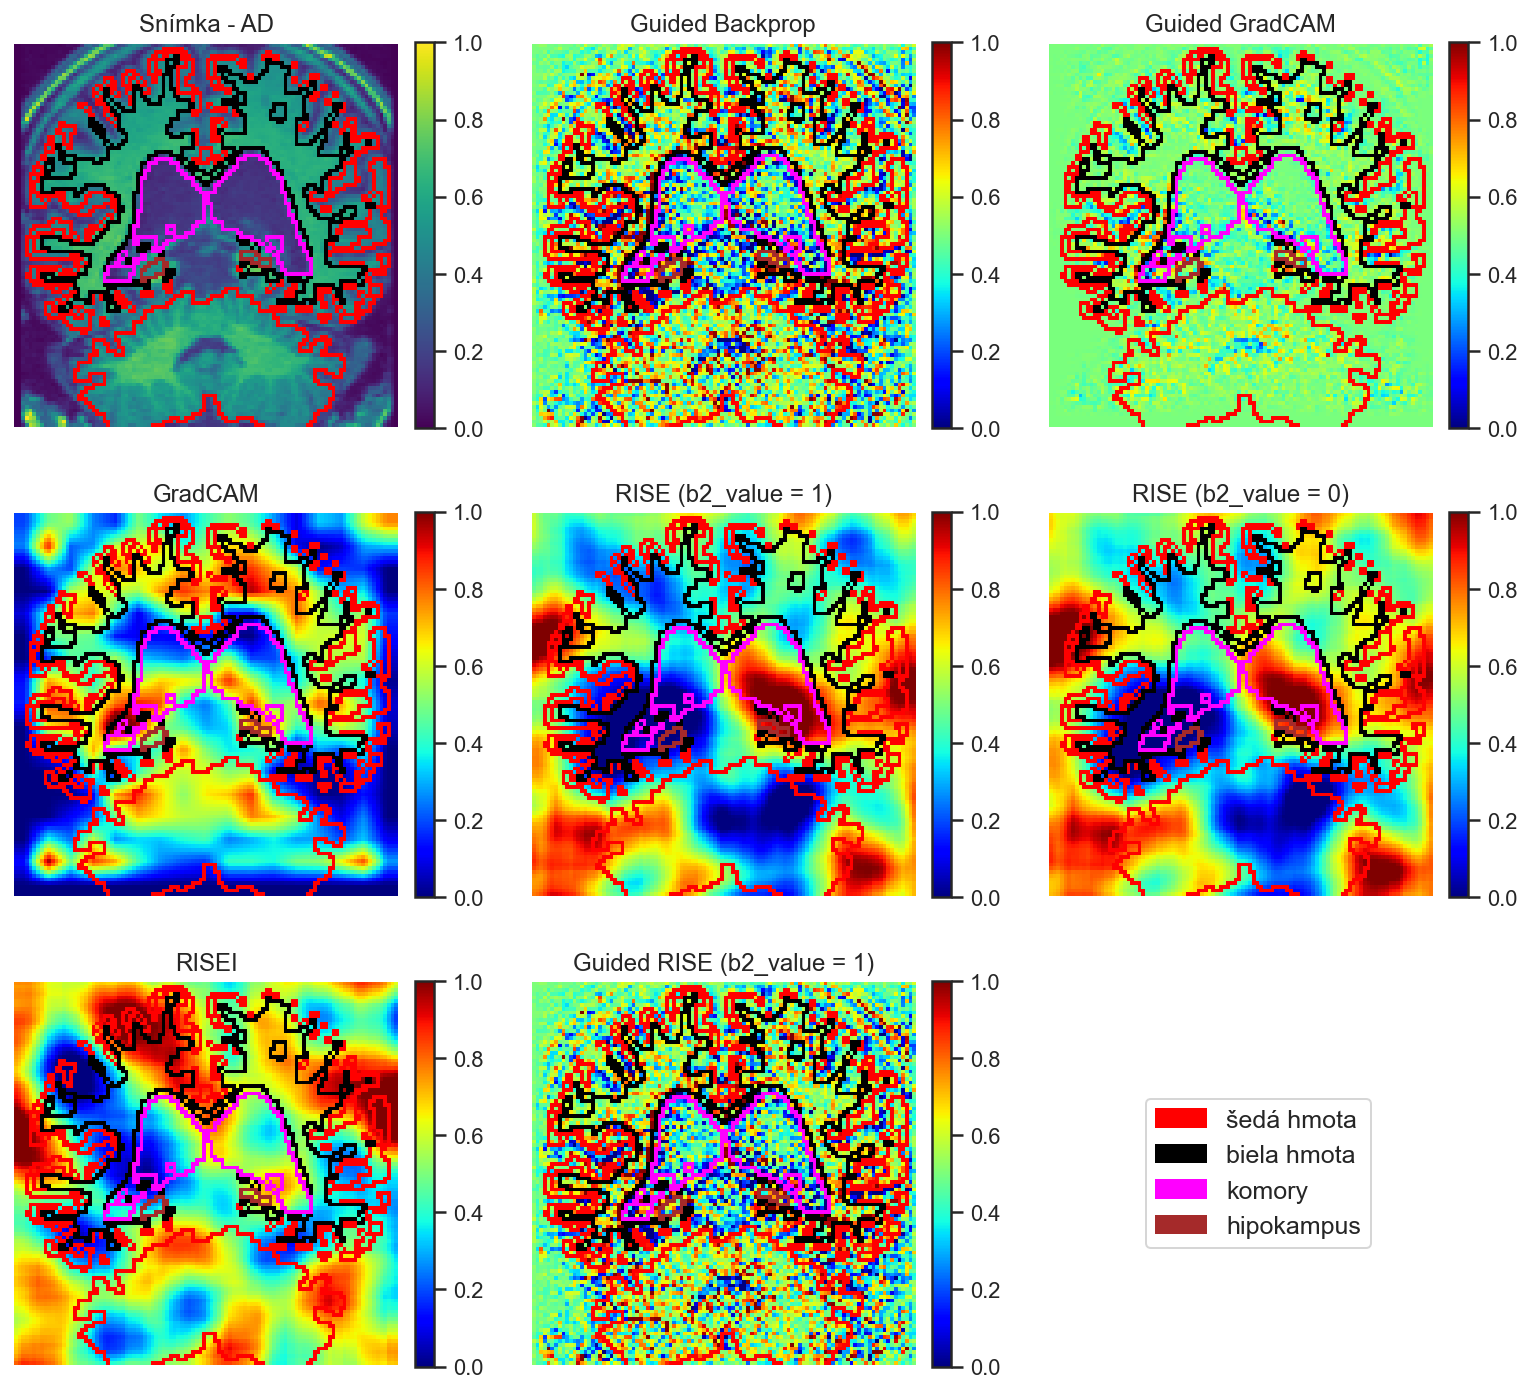

In [252]:
import tensorflow.keras.backend as K

IMAGE_IDX = 4
IMAGE_IDX = 9

def norm(arr):
    x = np.array(arr).copy()
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.25

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)
    return x

def imshow(ax, eval_idx, img_idx, no_heatmap=False):
    ax.set_axis_off()
    
    seg_mask, seg_label, image_x, image_y, heatmap, image_y_pred = evaluators[eval_idx].images[img_idx]

    if no_heatmap:
        alpha = 1
    else:
        alpha = 0
    
    return plot_segmentation(seg_mask, seg_label, image_x, image_y, norm(heatmap), 
                            dim_selector_factory(y=50), alpha=alpha, edges=True,
                            show_image=True, show_heatmap=True, hmap_imshow=hmap_imshow_factory(False, colorbar=False),
                            rotate_angle=2, legend=False, ax=ax)

fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(11, 10))
fig.tight_layout()
ax = axes.ravel()
            
_, _, _, image_y, _, _ = evaluators[0].images[IMAGE_IDX]
imshow(ax[0], 0, IMAGE_IDX, no_heatmap=True)
diagnosis = 'AD' if image_y[0] else 'CN'
ax[0].set_title(f'Snímka - {diagnosis}')

imshow(ax[1], 0, IMAGE_IDX)
ax[1].set_title(f'Guided Backprop')

imshow(ax[2], 1, IMAGE_IDX)
ax[2].set_title(f'Guided GradCAM')

imshow(ax[3], 2, IMAGE_IDX)
ax[3].set_title(f'GradCAM')

imshow(ax[4], 3, IMAGE_IDX)
ax[4].set_title(f'RISE (b2_value = 1)')

imshow(ax[5], 4, IMAGE_IDX)
ax[5].set_title(f'RISE (b2_value = 0)')

_, handles = imshow(ax[6], 5, IMAGE_IDX)
ax[6].set_title(f'RISEI')

imshow(ax[7], 6, IMAGE_IDX)
ax[7].set_title(f'Guided RISE (b2_value = 1)')

ax[8].set_axis_off()

norm = colors.Normalize(vmin=0, vmax=1, clip=False)
fig.colorbar(cm.ScalarMappable(norm=norm, cmap='viridis'), fraction=0.046, pad=0.04, ax=ax[0])

for idx in [1, 2, 3, 4, 5, 6, 7]:
# for idx in [2, 4, 5]:
    fig.colorbar(cm.ScalarMappable(norm=norm, cmap='jet'), fraction=0.046, pad=0.04, ax=ax[idx])
    
ax[8].legend(handles=handles, loc='center', fontsize='small')

[1. 0.]


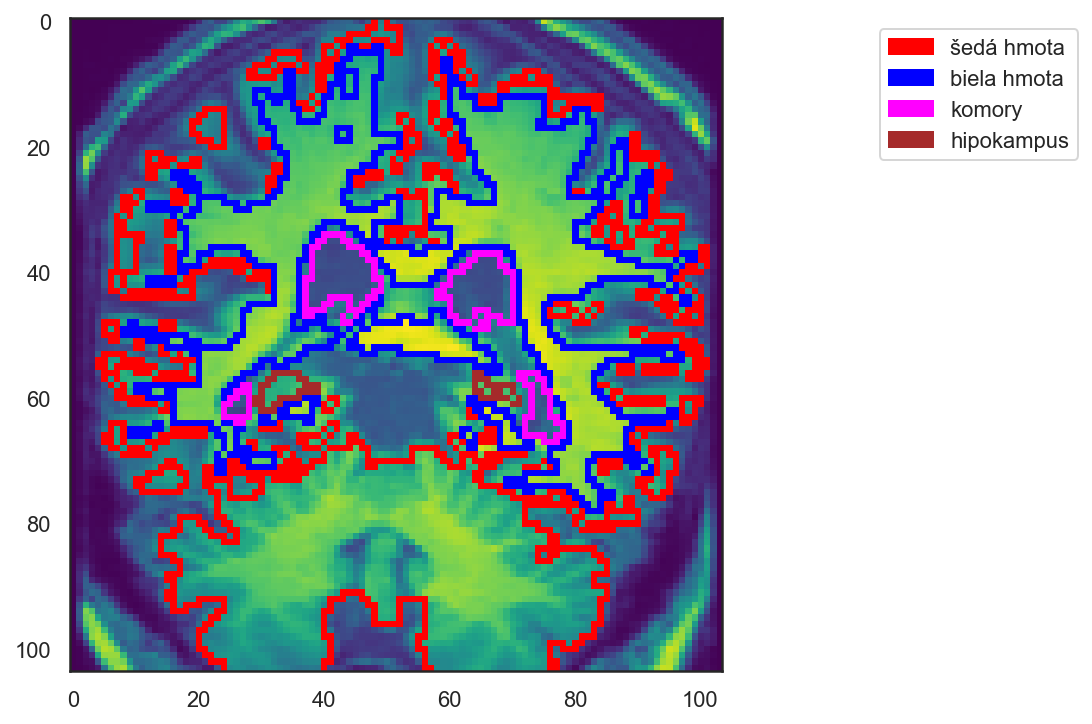

In [124]:
seg_mask, seg_label, image_x, image_y, heatmap, image_y_pred = evaluators[5].images[20]
print(image_y)

fig = plot_segmentation(seg_mask, seg_label, image_x, image_y, heatmap, 
                        dim_selector_factory(y=50), alpha=1, edges=True,
                        show_image=True, show_heatmap=False, hmap_imshow=hmap_imshow_factory(False),
                        rotate_angle=2, legend=False)

1.0489777011563841


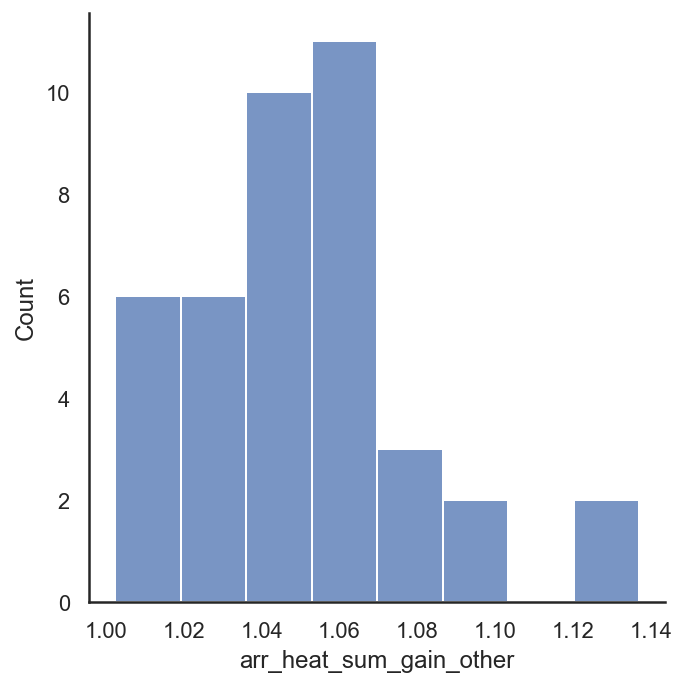

In [82]:
print(evaluator.df['arr_heat_sum_gain_other'].median())
sns.displot(evaluator.df['arr_heat_sum_gain_other'])

In [ ]:
# TODO: https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient